# 1. Import libraries and files

In [4]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
from catboost import CatBoostRegressor

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime


# import from previous notebook
import nbimporter
import Model10_four_models as FourModels

# import model
import pickle
import lightgbm
import os
import joblib

# import constants
import config

In [7]:
# >> enter the model we want to plot here
MODEL_NAME = "rf_random"
MODEL_NAME = "catboost_random"
# <<<<<<


# 2. Plot class

In [8]:
class Plot():
    def __init__(self):
        """pass"""
        # 1. reformat date index for plotting
        self.format_before = '%Y-%m-%d %H:%M:%S'
        self.format_after = '%H:%M'
                
    def plot(self,
             df_bldg,
             scene_name, 
             output_path="",
             is_save=False):
        
        """"A function that plot prediction and scenario or actual values of a single bldg. 
        Will save the images to output path if is_save is set to true"""
     
        # 1. Grab plot name from the column.
        predicted_plot_name = df_bldg.columns[1]
        actual_plot_name = df_bldg.columns[2]

        # 2. Format date to hour and minutes only.
        df_bldg.index = pd.to_datetime(df_bldg.index,
                                       format = self.format_before).strftime(self.format_after)
        # 3. Get bldgname.
        bldgname = df_bldg["bldgname"][0]

        # 4. Compute the mean difference.
        # (predicted - actual) / actual
        avg_diff = round(((df_bldg[predicted_plot_name].mean() - 
                df_bldg[actual_plot_name].mean())/df_bldg[actual_plot_name].mean())*100, 2) 
        
        # 5. Plot the actual data.
        ax = df_bldg.plot(
            y = actual_plot_name, 
            label = actual_plot_name,
            ylabel = config.CHWTON_SQM, 
            title = scene_name + " " + bldgname + "[avg diff= " + str(avg_diff) + "%]",
            figsize=(12, 6))

        # 6. Plot the predicted data.
        df_bldg.plot(y = predicted_plot_name, 
                     label = predicted_plot_name, 
                     ax=ax)


        # 7. Save the image.
        if is_save:
            # "./result/<model name>/<scene name>/"
            save_path = output_path +"/" + scene_name 
            isExist = os.path.exists(save_path)
            if not isExist:
               # Create a new directory if it does not exist.
               os.makedirs(save_path)

            fig = ax.get_figure()
            fig.savefig(save_path + "/" + bldgname +'_' + scene_name + '.png')
            
                


# 4. Scoring Class

In [9]:
class Scoring():
    def __init__(self):
        # create df to store scores per bldg
        columns=['model',
                 'bldgname', 
                 "r2_val", 
                 'r2', 
                 "mae",
                 "mape",
                 "mse",
                 'rmse',
                 'mbe']

        self.df_scores= pd.DataFrame()
        self.combined_name = "combined"
        self.format_5f = "{0:.5f}"
        self.format_7f = "{0:.7f}"
        
    def get_df_scores(self):
        return self.df_scores
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe
    
    def compute_all_metrics(self, df, model_name):
        
        # 0. set bldgname:
        # check if its all bldg or a single bldg
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get all scores
        r2 = r2_score(y_actual, y_pred)
        mae = mean_absolute_error(y_actual, y_pred)
        mape = mean_absolute_percentage_error(y_actual, y_pred)
        mse = mean_squared_error(y_actual, y_pred)
        rmse = math.sqrt(mse)
        mbe = self.get_MBE(y_actual, y_pred)
        
        # 3. append score
        # - scores_df to display the scores for all our models
        new_row_data = {'model': model_name, 
                        "bldgname": bldgname, 
                        "r2_val": 0,
                        "r2": self.format_5f.format(r2), 
                        "mae": self.format_5f.format(mae),
                        "mape": self.format_5f.format(mape),
                        "mse": self.format_7f.format(mse),
                        'rmse': self.format_5f.format(rmse), 
                        'mbe': self.format_5f.format(mbe)
                       }
        
        new_row = pd.DataFrame.from_records([new_row_data])
        self.df_scores = pd.concat([self.df_scores, new_row])
        
        
    def compute_r2_val(self, df, model_name):
        
        # 0. set bldgname
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get r2
        r2 = r2_score(y_actual, y_pred)
        self.df_scores.loc[self.df_scores['bldgname']== bldgname, 'r2_val'] = self.format_5f.format(r2)


    def save_scores_csv(self, output_dir_path, model_name):
        self.df_scores.to_csv(output_dir_path + '/metrics_' + model_name + '.csv', index=False)
    

# 5. Import Data and Model

In [10]:
# 1. Load data and drop columns.
REL_HUMID_COLUMN = ['RelH_Mean']

# KW and HTTMBTU
HTMMBTU_SQM_COLUMN = ['HTmmBTU/SQM']
KW_COLUMN = ['KW']
HTMMBTU_COLUMN = ['HTmmBTU']

# AirTemp
AIR_TEMP_FACADE_COLUMNS = ['AirT_North', 'AirT_East', 'AirT_South', 'AirT_West']
AREA_COLUMNS = ['Area_North', 'Area_East', 'Area_South', 'Area_West', 'Area_Top']

# Long and Sum wave
LONG_WAVE_COLUMNS = ['LongW_North', 'LongW_East', 'LongW_South', 'LongW_West', 'LongW_Top']
SUM_WAVE_COLUMNS = ['SumW_North', 'SumW_East', 'SumW_South', 'SumW_West', 'SumW_Top']
DROPPED_COLS= AIR_TEMP_FACADE_COLUMNS + AREA_COLUMNS + SUM_WAVE_COLUMNS + LONG_WAVE_COLUMNS + HTMMBTU_COLUMN + HTMMBTU_SQM_COLUMN + KW_COLUMN + REL_HUMID_COLUMN

data_obj = FourModels.Data(config.TRAIN_FILE_PATH, config.TEST_FILE_PATH, DROPPED_COLS)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test= data_obj.get_xy_test()

# 2. Load Model
model_file_path = config.MODEL_DIR_PATH +"/"+ MODEL_NAME + ".sav"
if "lgbm" in MODEL_NAME:
    print("model path=", config.MODEL_DIR_PATH)
    model = joblib.load(config.MODEL_DIR_PATH)

else:
    model = pickle.load(open(model_file_path, 'rb'))

    
# 3. Test and confirm correct score
tt = FourModels.TrainTest(X_train_val, y_train_val, X_test, y_test)
tt.test_and_store_score(model, MODEL_NAME)
scores_all = tt.get_scores_df()
print(scores_all)


final X train val= Index(['KW/SQM', 'AirT_Mean', 'AbsH_Mean', 'ShortW_North', 'ShortW_East',
       'ShortW_South', 'ShortW_West', 'ShortW_Top', 'Shade_North',
       'Shade_East', 'Shade_South', 'Shade_West', 'Shade_Top',
       'bldgname_ISTB 4', 'bldgname_Psychology North', 'bldgname_Psychology'],
      dtype='object')
test_score: r2=0.9509618951809503, rmse=0.0011825350641268, mbe=0.0001800143597989586
             model r2_val   r2_test  rmse_test  mbe_test  train_time_s
0  catboost_random      0  0.950962   0.001183   0.00018           0.0


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


# 5. Prediction VS Actual

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


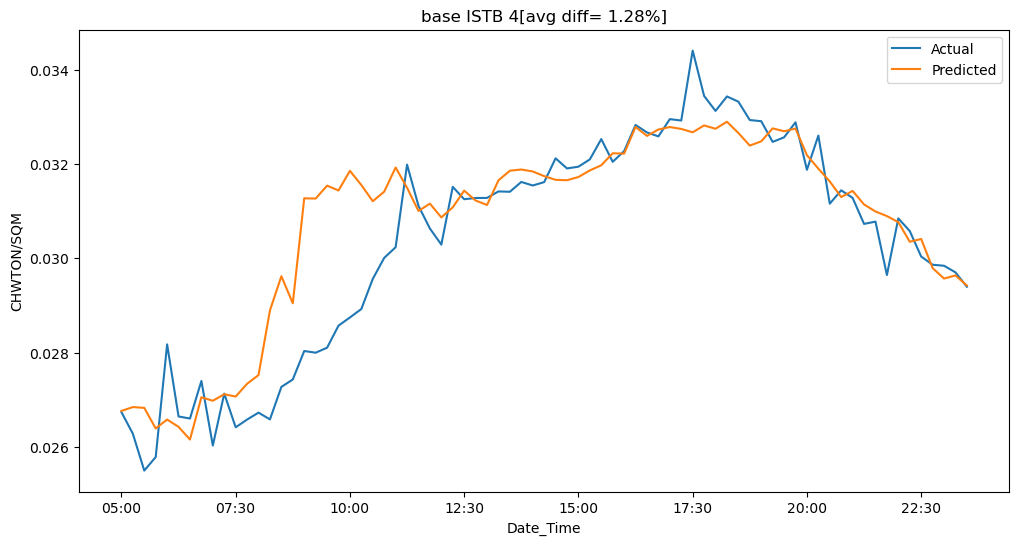

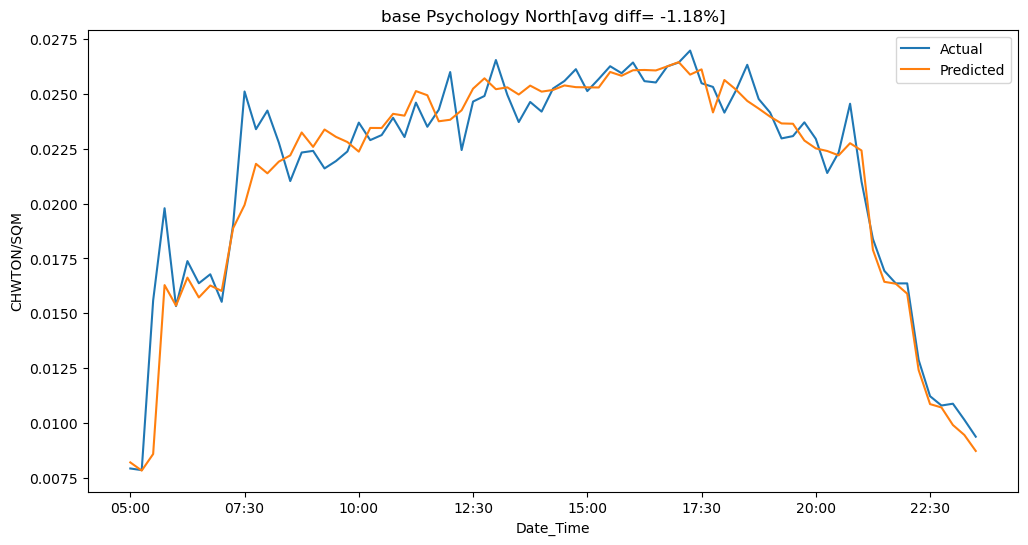

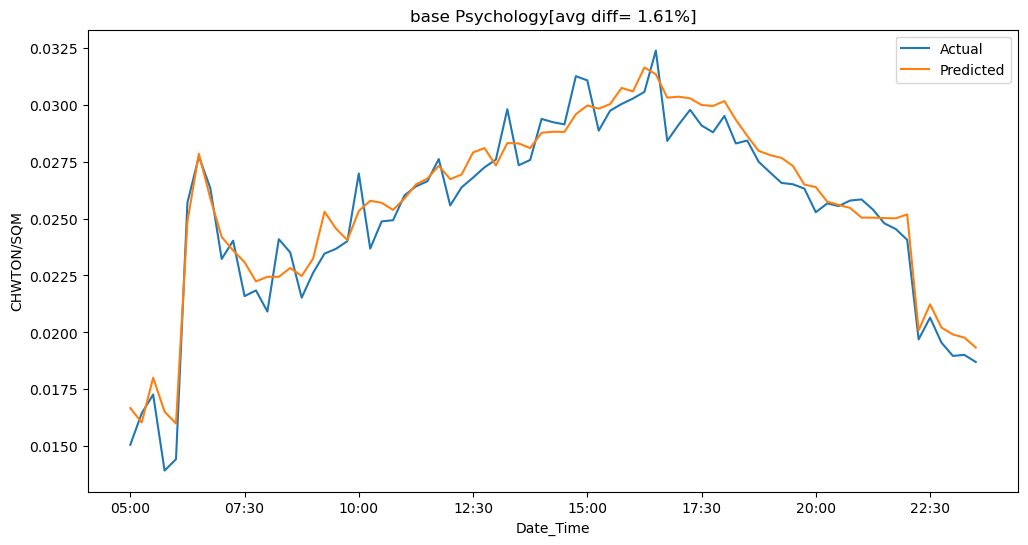

In [11]:
# 1. predict test data and create df_bldgs
y_pred = model.predict(X_test)
df_combined_test, df_bldgs_test = data_obj.create_prediction_actual_df(y_pred, y_test)

# 2. plot
plt_obj = Plot()
for df_bldg in df_bldgs_test:
    plt_obj.plot(df_bldg, 
                 "base", 
                 output_path=f"{config.RESULT_DIR_PATH}/{MODEL_NAME}", 
                 is_save=True)
    


In [12]:
# 3. Predict training data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                      y_train_val, 
                                                      test_size=0.3, 
                                                      random_state=20)
y_pred_val = model.predict(X_val)
df_combined_val, df_bldgs_val = data_obj.create_prediction_actual_df(y_pred_val,
                                                         y_val, 
                                                         is_val=True)


In [27]:
df_bldgs_test

[          bldgname  Predicted    Actual
 Date_Time                              
 05:00       ISTB 4   0.026763  0.026739
 05:15       ISTB 4   0.026845  0.026280
 05:30       ISTB 4   0.026829  0.025499
 05:45       ISTB 4   0.026393  0.025786
 06:00       ISTB 4   0.026581  0.028175
 ...            ...        ...       ...
 22:30       ISTB 4   0.030409  0.030036
 22:45       ISTB 4   0.029792  0.029863
 23:00       ISTB 4   0.029569  0.029841
 23:15       ISTB 4   0.029635  0.029701
 23:30       ISTB 4   0.029422  0.029395
 
 [75 rows x 3 columns],
                    bldgname  Predicted    Actual
 Date_Time                                       
 05:00      Psychology North   0.008203  0.007926
 05:15      Psychology North   0.007831  0.007851
 05:30      Psychology North   0.008586  0.015583
 05:45      Psychology North   0.016282  0.019785
 06:00      Psychology North   0.015351  0.015325
 ...                     ...        ...       ...
 22:30      Psychology North   0.010860  

## Get scores for each bldg

In [13]:
# 1. init scoring object
scoring_obj = Scoring()

# 2. compute scores for each bldg
for df_bldg in df_bldgs_test:
    scoring_obj.compute_all_metrics(df_bldg, MODEL_NAME)
    
for df_bldg in df_bldgs_val:
    scoring_obj.compute_r2_val(df_bldg, MODEL_NAME)
    
    
# # 3. compute scores combined
scoring_obj.compute_all_metrics(df_combined_test, MODEL_NAME)
scoring_obj.compute_r2_val(df_combined_val, MODEL_NAME)

# # 4. grab result
df_scores = scoring_obj.get_df_scores()
df_scores

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.98753' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,model,bldgname,r2_val,r2,mae,mape,mse,rmse,mbe
0,catboost_random,ISTB 4,0.98753,0.76059,0.00073,0.02503,0.0000013,0.00114,0.00039
0,catboost_random,Psychology North,0.97086,0.92049,0.00089,0.04328,0.0000020,0.00140,-0.00026
0,catboost_random,Psychology,0.95279,0.94412,0.00080,0.03418,0.0000009,0.00097,0.00041
0,catboost_random,combined,0.98279,0.95096,0.00081,0.03416,0.0000014,0.00118,0.00018


In [14]:
scoring_obj.save_scores_csv(config.RESULT_DIR_PATH, MODEL_NAME)

# 6. Scenario VS Actual Data Preparation.

Make the model predict the CHWTON for July 7th on the scenario data.
Compare this with the actual CHWTON for non scenario data.

In [15]:
final_cols = ['KW/SQM', 'AirT_Mean', 'AbsH_Mean', 'ShortW_North', 'ShortW_East',
              'ShortW_South', 'ShortW_West', 'ShortW_Top', 'Shade_North',
              'Shade_East', 'Shade_South', 'Shade_West', 'Shade_Top',
              'bldgname_ISTB 4', 'bldgname_Psychology North', 'bldgname_Psychology', 'CHWTON/SQM']

def filter_df(df, final_cols, test_date):
    """
    Function to filter the data frame to drop all columns apart from that in `final_cols`.
    Also exclude all data with dates outside of `TEST_DATE`.
    """
    # Filter date.
    # Set the 'Date_Time' column as the index of the DataFrame.
    df[config.DATE_TIME] = pd.to_datetime(df[config.DATE_TIME])

    # Only get data on test_date.
    date_filter = df[config.DATE_TIME].dt.date == pd.to_datetime(config.TEST_DATE).date()
    df = df[date_filter]
    df.set_index(config.DATE_TIME, inplace=True)

    # Drop cols that are not in final_cols:
    cols_to_drop = [col for col in df.columns if col not in final_cols]

    return df.drop(columns=cols_to_drop)



## 6.1 Get Scenario Data.

In [20]:
# scenario = config.TREES_EXTREME
# scenario = config.HIGH_ALBEDO_WALLS
# scenario = config.COOL_PAVEMENT
# scenario = config.WALL_SHADE # mismatch rows
scenario = config.TREES_SURROUND
scenario = config.PV_ROOFTOP # OFF
# scenario = config.PV_ROOFTOP_TREES # GOOD
# scenario = config.PV_SIDEWALKS # OFF
scenario_dir_path = f"{config.SCENARIOS_DIR_PATH}/{scenario}"
scenario_name = scenario_dir_path.split('/')[-1]

# Create combine csv files from the separate building data for scenarios.
FourModels.combine_csv(scenario_dir_path, config.THREE_BLDGS_FILENAME)

# Load scenario dataframe.
three_bldgs_scenario_df = pd.read_csv(f"{scenario_dir_path}/{config.THREE_BLDGS_FILENAME}.csv")

# Filter by date and remove unused variables.
three_bldgs_scenario_df = filter_df(three_bldgs_scenario_df, final_cols, config.TEST_DATE)
X_scenario = three_bldgs_scenario_df.drop(columns=[config.CHWTON_SQM])


loading from....: ../data/dataset2/scenarios/pv_rooftop/Psychology_North.csv
loading from....: ../data/dataset2/scenarios/pv_rooftop/Istb_4.csv
loading from....: ../data/dataset2/scenarios/pv_rooftop/Psychology.csv


## 6.1. Get Actual Data.

In [21]:
three_bldgs_actual_df = pd.read_csv(f"{config.BASE_PATH}/{config.THREE_BLDGS_FILENAME}.csv")
three_bldgs_actual_df = filter_df(three_bldgs_actual_df, final_cols, config.TEST_DATE)
y_actual = three_bldgs_actual_df[config.CHWTON_SQM]

# 7. Plot Scenario Prediction

In [22]:
# 1. make prediction 
y_scenario = model.predict(X_scenario)



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


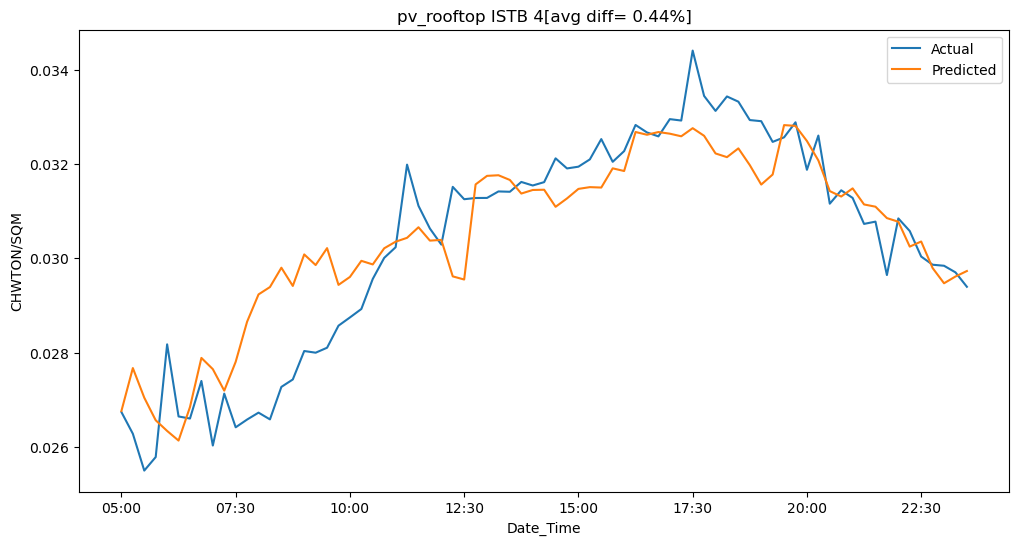

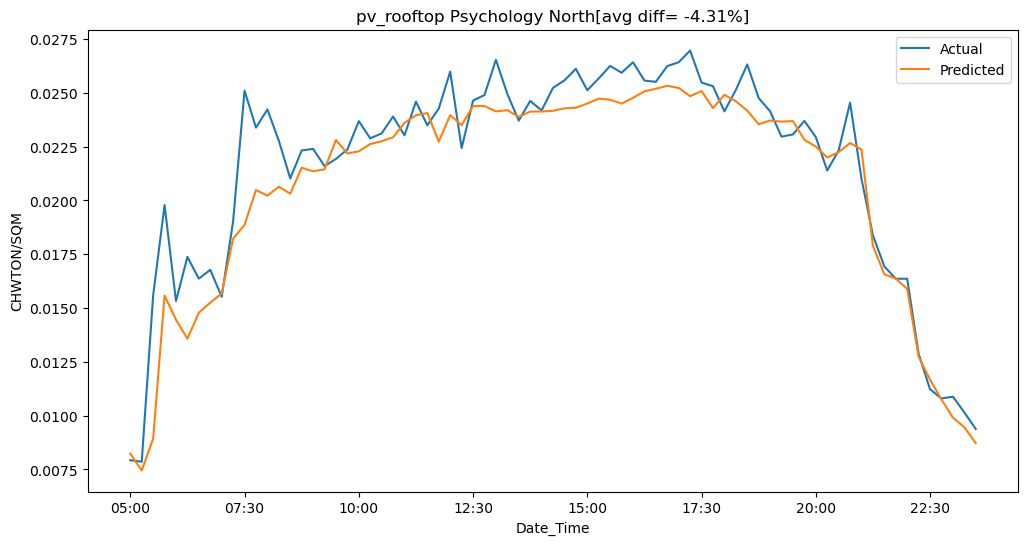

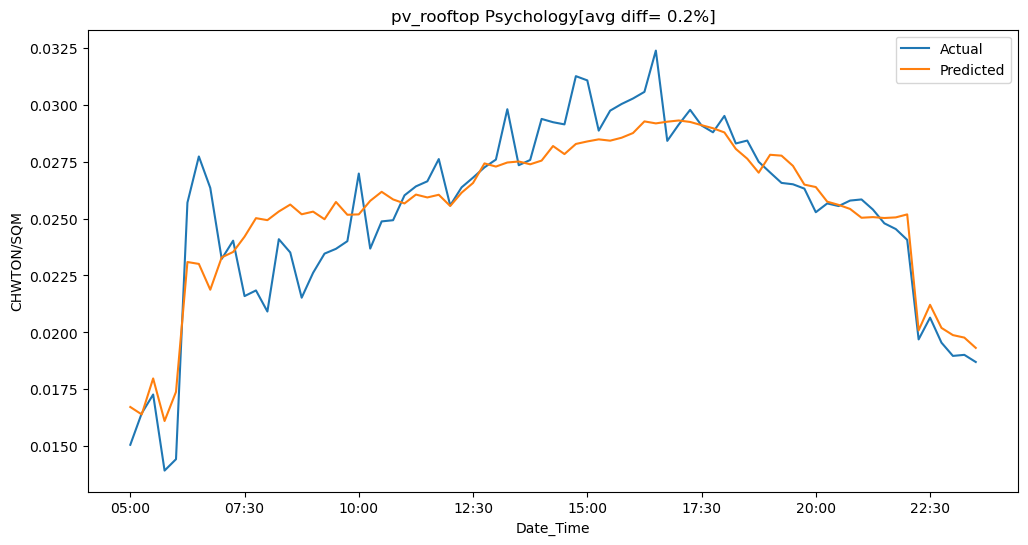

In [23]:
df_combined, df_bldgs = data_obj.create_prediction_actual_df_input(y_scenario,
                                                       y_actual,
                                                       three_bldgs_actual_df)

# # 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 scenario_name, 
                 output_path=f"{config.RESULT_DIR_PATH}/{MODEL_NAME}", 
                 is_save=True)